In [3]:
# !pip install --upgrade transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 26.2 MB/s eta 0:00:00


In [4]:
#Import package
import tensorflow as tf
import torch
import pandas as pd
import numpy as np
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4
import time
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# function to seed the script globally
torch.manual_seed(0)
#nltk 
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


#transformers 
from transformers import (
    BertForSequenceClassification,
     TFBertForSequenceClassification, 
                          BertTokenizer,
                           TFRobertaForSequenceClassification,
                          RobertaForSequenceClassification,
                          RobertaTokenizer,
                          AutoTokenizer, XLNetForSequenceClassification,
                         AdamW)
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModelForSequenceClassification, Trainer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
# mount
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Challenge_INF582/")

## Getting State-of-the-Art results on sequence classification

In order to get State-of-the-Art results on this task, we will fine-tune our models on a given dataset. Fine-tuning a model means that we will slightly train it on top of an already trained checkpoint. The learning rate will be very low, as having it to high would result in catastrophic forgetting -> the model would forget what it had learned until now semantically and syntaxically.

We will follow the procedure detailed below:
1. Installing required dependencies
2. Loading both Fake and Real news data
3. Preprocess the text - Data Cleaning & Standardisation
4. Initiatizing pretrained models - BERT & RoBERTa
5. Tokenzie this dataset so that it can be used by the model
6. Train and Test split
7. Set-up a training loop; train the model on the training data
8. Evaluate the model on the testing data by comparing to the actual results

## Set device to GPU

In [ ]:
# set device
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


#### 2. Load Data

In [ ]:
train_df = pd.read_json('./train_set.json')
test_df = pd.read_json('./test_set.json')
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))
print('Number of testing sentences: {:,}\n'.format(test_df.shape[0]))

Number of training sentences: 4,000

Number of testing sentences: 4,000



### 3. Pre-processing Text

In [ ]:
# view text before preprocess
train_df['text'].head()

0    Remains dating to the 5th century were found i...
1    Professional Identification is a type of socia...
2    A magistrate has refused a media ban on the tr...
3    The Conservation Commons is the expression of ...
4    Myer is holding a 75 per cent of designer labe...
Name: text, dtype: object

In [ ]:
# # Define the split function
# def split(text):
#     split_index = int(len(text)/3)
#     part1 = text[:split_index]
#     part2 = text[split_index:2*split_index]
#     part3 = text[2*split_index:]
#     return part1, part2, part3

# # Apply the split function to each row of the dataframe
# train_df[['subtext1', 'subtext2','subtext3']] = train_df['text'].apply(split).apply(pd.Series)
# train_df = train_df.drop(columns='text',axis=1)
# df2 = train_df[['label', 'subtext2']].rename(columns={'subtext2': 'text'})
# df3 = train_df[['label', 'subtext1']].rename(columns={'subtext1': 'text'})
# df4 = train_df[['label', 'subtext3']].rename(columns={'subtext3': 'text'})
# train_df = pd.concat([df2, df3,df4], ignore_index=True)

In [ ]:
# print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

In [ ]:
# # # Check if any value in the dataframe is None
# # if train_df.isnull().values.any():
# #     print("Dataframe contains None values")
#       # Drop rows with any None value
#       train_df.dropna(inplace=True)
# # else:
# #     print("Dataframe does not contain None values")

In [ ]:
# import re
# def clean_text(text):
#     text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
#     text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
#     text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
#     text = re.sub('\t', ' ',  text)
#     text = re.sub(r" +", ' ', text)
#     stop_words = set(stopwords.words('english'))
#     text_tokens = text.split()
#     text = ' '.join([word for word in text_tokens if not word.lower() in stop_words])
#     return text

In [ ]:
# train_df['text'] = train_df['text'].apply(clean_text)
# test_df['text'] = test_df['text'].apply(clean_text)

In [ ]:
# Get the lists of train sentences and train labels
sentences = train_df['text'].values
labels = train_df['label'].values

In [ ]:
train_df.head()

,id,text,label
0,0,Remains dating to the 5th century were found i...,1
1,1,Professional Identification is a type of socia...,1
2,2,A magistrate has refused a media ban on the tr...,1
3,3,The Conservation Commons is the expression of ...,1
4,4,Myer is holding a 75 per cent of designer labe...,0


### Features Engineering and Extraction

various ways to improve the feature engineering pipeline:

- Word Embeddings: Word embeddings are vector representations of words in a high-dimensional space. Using pre-trained word embeddings such as Word2Vec, GloVe or FastText can capture semantic and syntactic similarities between words. These embeddings can be used to replace one-hot encoded vectors in the input layer of a neural network.

- Part-of-speech (POS) tagging: POS tagging is the process of labeling each word in a sentence with its corresponding part of speech (e.g., noun, verb, adjective, etc.). This information can be used to capture grammatical structure and improve the accuracy of the model.

- Named Entity Recognition (NER): NER is the process of identifying and classifying named entities in a sentence (e.g., person, organization, location, etc.). This information can be used to capture the semantic meaning of the text and improve the accuracy of the model.

- Sentiment Analysis: Sentiment analysis is the process of identifying the sentiment (positive, negative, neutral) of a text. This information can be used to capture the emotional tone of the text and improve the accuracy of the model.

- Topic Modeling: Topic modeling is the process of identifying the topics present in a text. This information can be used to capture the subject matter of the text and improve the accuracy of the model.

- Text Summarization: Text summarization is the process of reducing a text to its most important information. This information can be used as a feature to capture the most important aspects of the text and improve the accuracy of the model.

- Syntactic Parsing: Syntactic parsing is the process of analyzing the grammatical structure of a sentence. This information can be used to capture the relationships between words in the text and improve the accuracy of the model.

- Word Frequency: Counting the frequency of words in the text can be used as a feature to capture the importance of each word in the text and improve the accuracy of the model.

These are just a few ways to improve the feature engineering pipeline. Depending on the data and the problem, different techniques may be more effective than others.

In [47]:
import json
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC



from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score, classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import re
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from transformers import pipeline

import spacy
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from datetime import datetime

#### Tfidf + simple models ( LogisticRegression, MultinomialNB, LinearSVC, RandomForestClassifier)

In [48]:
# Load the data
with open('/content/sample_data/train_set.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract the text and labels
texts = [d['text'] for d in data]
labels = [d['label'] for d in data]

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.1, random_state=42)

# Feature engineering using TfidfVectorizer
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(train_texts)
val_features = vectorizer.transform(val_texts)

# Train and evaluate models
models = {
    'Logistic Regression': LogisticRegression(),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(),
    'Random Forest': RandomForestClassifier()
}

for name, model in models.items():
    model.fit(train_features, train_labels)
    train_preds = model.predict(train_features)
    val_preds = model.predict(val_features)
    train_acc = accuracy_score(train_labels, train_preds)
    val_acc = accuracy_score(val_labels, val_preds)
    print(f'{name}:\n\tTraining accuracy: {train_acc:.3f}\n\tValidation accuracy: {val_acc:.3f}')


Logistic Regression:
	Training accuracy: 0.929
	Validation accuracy: 0.657
Multinomial Naive Bayes:
	Training accuracy: 0.961
	Validation accuracy: 0.585
Linear SVM:
	Training accuracy: 0.999
	Validation accuracy: 0.635
Random Forest:
	Training accuracy: 1.000
	Validation accuracy: 0.657


#### Sequence Models (N-grams, tfidf+N-grams, tfidf_chars) + simple models (svm(svc), naive_bayes, Random Forest, Gradient Boosting)

In [52]:
# Load the data
with open('/content/sample_data/train_set.json') as file:
    data_train = json.load(file)

#with open('/content/sample_data/test_set.json') as file:
#    data_test = json.load(file)

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Extract the text and labels from the data
X_train = train_texts
y_train = train_labels
X_test = val_texts

# Define the feature engineering techniques
vectorizers = {
    'count': CountVectorizer(),
    'tfidf': TfidfVectorizer(),
    'binary': CountVectorizer(binary=True),
    'bigram': CountVectorizer(ngram_range=(2, 2)),
    'trigram': CountVectorizer(ngram_range=(3, 3)),
    'tfidf_bigram': TfidfVectorizer(ngram_range=(2, 2)),
    'tfidf_trigram': TfidfVectorizer(ngram_range=(3, 3)),
    'tfidf_chars': TfidfVectorizer(analyzer='char', ngram_range=(3, 6))
}

# Apply the feature engineering techniques to the training and test data
X_train_featurized = {}
X_test_featurized = {}
for name, vectorizer in vectorizers.items():
    X_train_featurized[name] = vectorizer.fit_transform(X_train)
    X_test_featurized[name] = vectorizer.transform(X_test)

# Define the classification algorithms
classifiers = {
    'logistic_regression': LogisticRegression(),
    'svm': SVC(kernel='linear'),
    'naive_bayes': MultinomialNB(),
    'random_forest': RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Train and evaluate each classifier on each set of features
results = {}
for vec_name, X_train_vec in X_train_featurized.items():
    for clf_name, clf in classifiers.items():
        clf.fit(X_train_vec, y_train)
        y_pred = clf.predict(X_test_featurized[vec_name])
        results[(clf_name, vec_name)] = y_pred


In [53]:
# Evaluate the results using accuracy and F1-score
eval_results = {}
for key, y_pred in results.items():
    clf_name, vec_name = key
    acc = accuracy_score(val_labels, y_pred)
    f1 = f1_score(val_labels, y_pred) # , pos_label='AI')
    eval_results[(clf_name, vec_name)] = {'accuracy': acc, 'f1_score': f1}

# Print the evaluation results
df_eval_results = pd.DataFrame(eval_results).T
df_eval_results = df_eval_results[['accuracy', 'f1_score']]
print(df_eval_results)

                                   accuracy  f1_score
logistic_regression count           0.60500  0.604010
svm                 count           0.60250  0.607407
naive_bayes         count           0.54750  0.558537
random_forest       count           0.64875  0.653514
Gradient Boosting   count           0.64375  0.653706
logistic_regression tfidf           0.62500  0.634146
svm                 tfidf           0.62875  0.631970
naive_bayes         tfidf           0.56250  0.583333
random_forest       tfidf           0.66000  0.658291
Gradient Boosting   tfidf           0.69125  0.693168
logistic_regression binary          0.61500  0.610127
svm                 binary          0.60000  0.593909
naive_bayes         binary          0.55250  0.545685
random_forest       binary          0.59625  0.596754
Gradient Boosting   binary          0.60625  0.592497
logistic_regression bigram          0.61875  0.638197
svm                 bigram          0.59375  0.611708
naive_bayes         bigram  

###### save the DataFrame for latex 

In [6]:
df_eval_results.to_latex()

<ipython-input-6-4b3763dd771b>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_eval_results.to_latex()


'\\begin{tabular}{llrr}\n\\toprule\n              &             &  accuracy &  f1\\_score \\\\\n\\midrule\nlogistic\\_regression & count &   0.60500 &  0.604010 \\\\\nsvm & count &   0.60250 &  0.607407 \\\\\nnaive\\_bayes & count &   0.54750 &  0.558537 \\\\\nrandom\\_forest & count &   0.66375 &  0.669127 \\\\\nGradient Boosting & count &   0.65875 &  0.668287 \\\\\nlogistic\\_regression & tfidf &   0.62500 &  0.634146 \\\\\nsvm & tfidf &   0.62875 &  0.631970 \\\\\nnaive\\_bayes & tfidf &   0.56250 &  0.583333 \\\\\nrandom\\_forest & tfidf &   0.67250 &  0.670025 \\\\\nGradient Boosting & tfidf &   0.69125 &  0.692403 \\\\\nlogistic\\_regression & binary &   0.61500 &  0.610127 \\\\\nsvm & binary &   0.60000 &  0.593909 \\\\\nnaive\\_bayes & binary &   0.55250 &  0.545685 \\\\\nrandom\\_forest & binary &   0.62000 &  0.610256 \\\\\nGradient Boosting & binary &   0.59875 &  0.591083 \\\\\nlogistic\\_regression & bigram &   0.61875 &  0.638197 \\\\\nsvm & bigram &   0.59375 &  0.61170

#####  Final graph for the Accuracy of each model

In [39]:
df = df_eval_results.reset_index()
df["Model"] = df["level_0"] + " + " + df["level_1"] 
df = df.drop(columns=["level_0","level_1"]).set_index("Model")
df

,accuracy,f1_score
Model,,
logistic_regression + count,0.60500,0.604010
svm + count,0.60250,0.607407
naive_bayes + count,0.54750,0.558537
random_forest + count,0.67250,0.673317
Gradient Boosting + count,0.64875,0.660218
logistic_regression + tfidf,0.62500,0.634146
svm + tfidf,0.62875,0.631970
naive_bayes + tfidf,0.56250,0.583333
random_forest + tfidf,0.67375,0.680539


In [35]:
df.to_latex()

<ipython-input-35-893b2df4225d>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex()


'\\begin{tabular}{lrr}\n\\toprule\n{} &  accuracy &  f1\\_score \\\\\nModel                               &           &           \\\\\n\\midrule\nlogistic\\_regression + count         &   0.60500 &  0.604010 \\\\\nsvm + count                         &   0.60250 &  0.607407 \\\\\nnaive\\_bayes + count                 &   0.54750 &  0.558537 \\\\\nrandom\\_forest + count               &   0.67250 &  0.673317 \\\\\nGradient Boosting + count           &   0.64875 &  0.660218 \\\\\nlogistic\\_regression + tfidf         &   0.62500 &  0.634146 \\\\\nsvm + tfidf                         &   0.62875 &  0.631970 \\\\\nnaive\\_bayes + tfidf                 &   0.56250 &  0.583333 \\\\\nrandom\\_forest + tfidf               &   0.67375 &  0.680539 \\\\\nGradient Boosting + tfidf           &   0.69125 &  0.693168 \\\\\nlogistic\\_regression + binary        &   0.61500 &  0.610127 \\\\\nsvm + binary                        &   0.60000 &  0.593909 \\\\\nnaive\\_bayes + binary                &   0.552

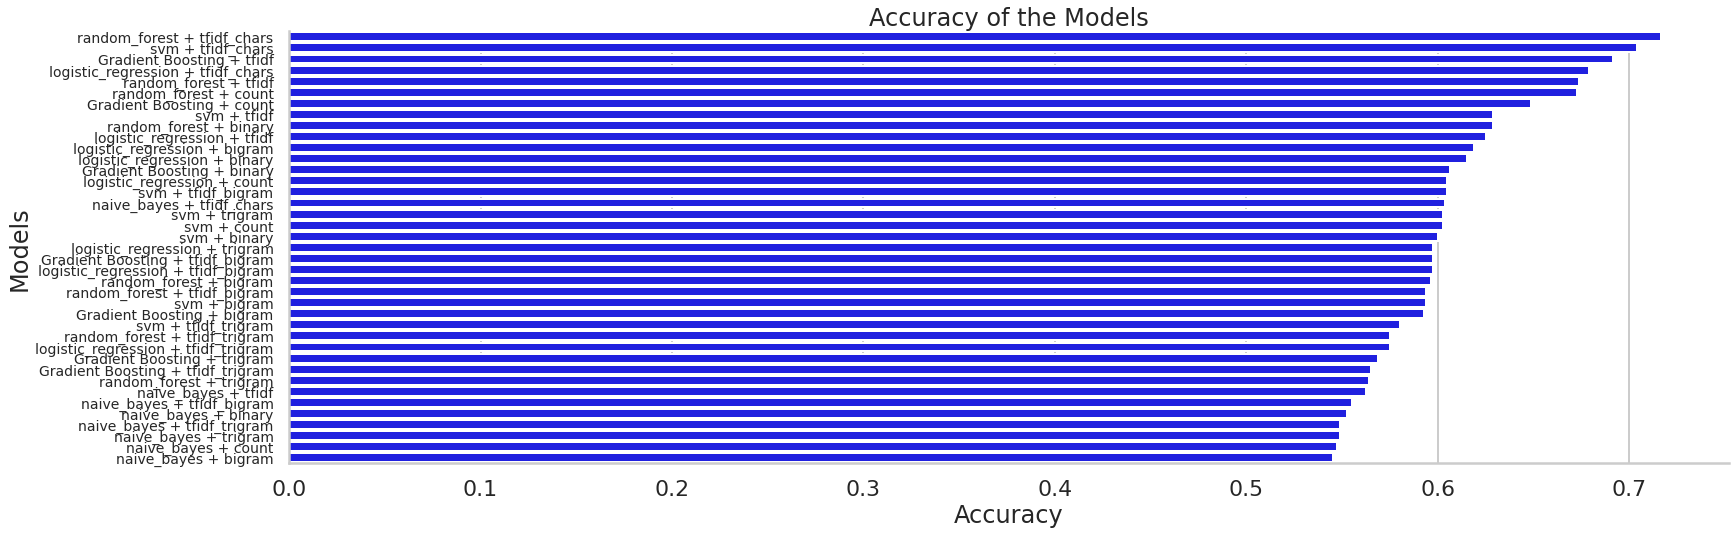

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

models=df.sort_values(by=['accuracy','f1_score'], ascending=False) # .iloc[:10]

# set style and context using Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

fig = plt.figure(figsize=(20,6))
ax = fig.add_axes([0,0,1,1])
modelz = models.index # or models['Model]
nums = models.accuracy # or models['accuracy']

# use a horizontal bar chart instead
sns.barplot(y=modelz, x=nums, color='blue', ax=ax)

# add labels and title
plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.title('Accuracy of the Models')

# remove spines and set ytick labels size
sns.despine()
ax.tick_params(axis='y', labelsize=14)
plt.savefig('Summary_plot.pdf')

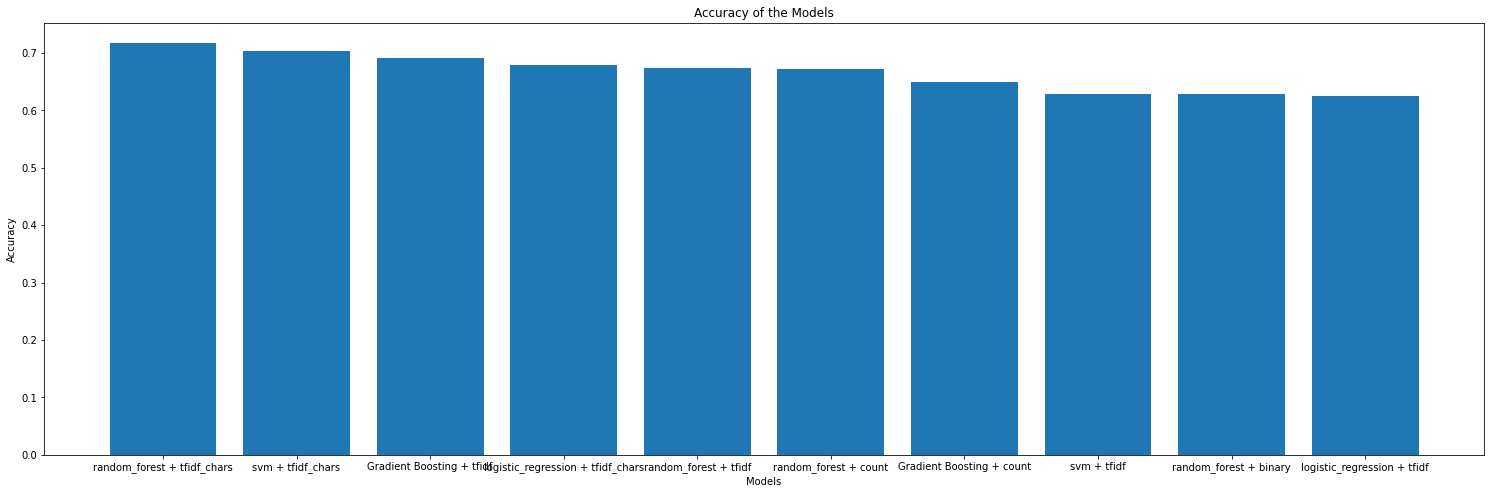

In [46]:
models=df.sort_values(by=['accuracy','f1_score'], ascending=False) # .iloc[:10]
fig = plt.figure(figsize=(20,6))
ax = fig.add_axes([0,0,1,1])
modelz = models.index # or models['Model]
nums = models.accuracy # or models['accuracy']
ax.bar(modelz,nums)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of the Models')
plt.savefig('Summary_plot.pdf')

<ipython-input-64-81591fc21ba0>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(models.index, fontsize=12, rotation=90)


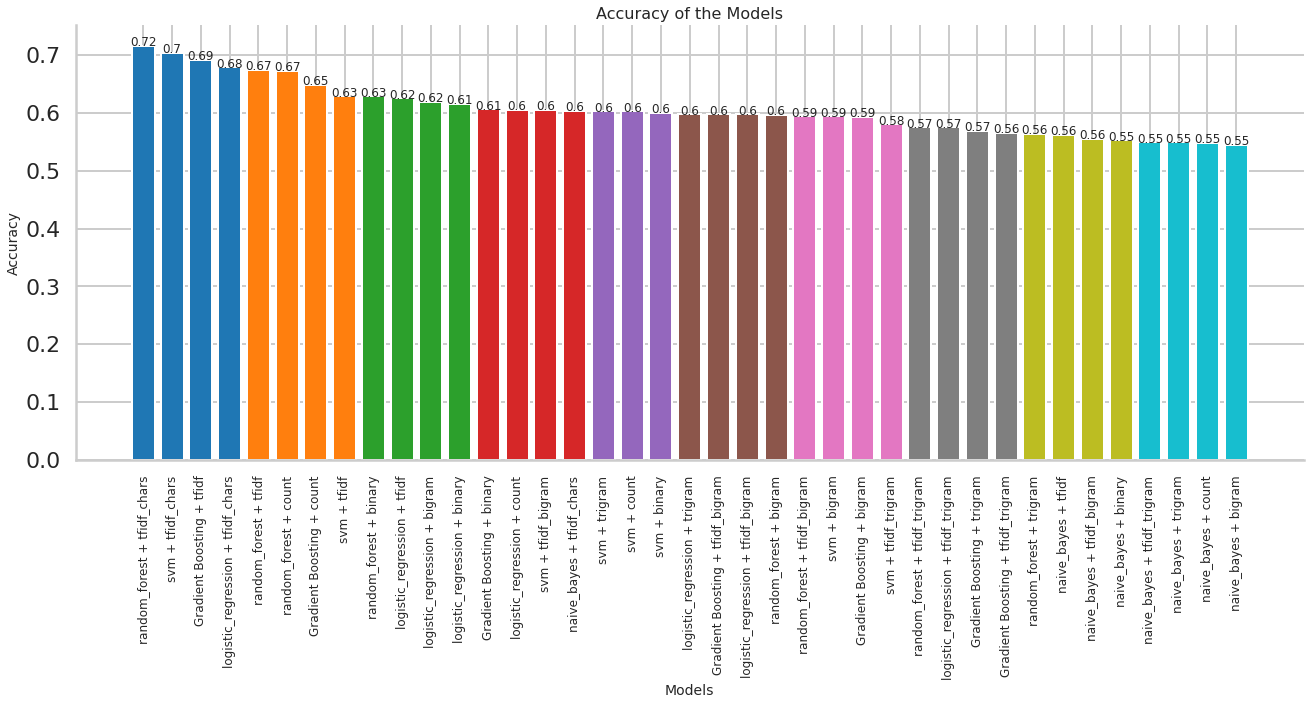

In [64]:
import numpy as np
import matplotlib.pyplot as plt

models = df.sort_values(by=['accuracy', 'f1_score'], ascending=False)

fig, ax = plt.subplots(figsize=(22, 8))

# Define color map
cmap = plt.get_cmap('tab10')

# Define bar chart colors
colors = [cmap(i) for i in np.linspace(0, 1, len(models))]

# Plot the bar chart
ax.bar(models.index, models['accuracy'], color=colors)

# Add labels to each bar
for i, acc in enumerate(models['accuracy']):
    ax.text(i, acc, round(acc, 2), ha='center', fontsize=12)

# Set x-axis tick labels
ax.set_xticklabels(models.index, fontsize=12, rotation=90)

# Add axis labels and title
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title('Accuracy of the Models', fontsize=16)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.savefig('histogram_models.pdf', dpi=300, bbox_inches='tight')
#plt.show()
#plt.savefig('Summary_plot.pdf')

##### Select the best Model: tfidf_chars + GradientBoostingClassifier

In [ ]:
# Extract the text and labels

# Load the data
with open('/content/sample_data/train_set.json') as file:
    data_train = json.load(file)

with open('/content/sample_data/test_set.json') as file:
    data_test = json.load(file)

texts = [d['text'] for d in data_train]
labels = [d['label'] for d in data_train]

tests = [d['text'] for d in data_test]

vect=TfidfVectorizer(analyzer='char', ngram_range=(3, 6))

X_train_featurized = vect.fit_transform(texts)
X_test_featurized = vect.transform(tests)

clf=GradientBoostingClassifier()
clf.fit(X_train_featurized, labels)

y_pred = clf.predict(X_test_featurized)

# Write predictions to a file
with open("submission.csv", "w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','label'])
    for i, row in enumerate(y_pred):
        csv_out.writerow([i, row])

In [63]:
# Load pre-trained LLM model
nlp = pipeline("feature-extraction", model="distilbert-base-uncased")

# Load data
data = pd.read_json("/content/sample_data/train_set.json")
# test_data = pd.read_json("/content/sample_data/test_set.json")

train_data,test_data = train_test_split(data, test_size=0.1, random_state=42)
# Preprocess data
def preprocess(text):
    text = re.sub(r"[^a-zA-Z0-9]+", ' ', text)  # remove special characters
    text = text.lower()  # convert to lowercase
    return text

train_data['text'] = train_data['text'].apply(preprocess)
test_data['text'] = test_data['text'].apply(preprocess)

# Compute Word Frequency features
vectorizer = CountVectorizer()
tfidf_transformer = TfidfTransformer()
train_counts = vectorizer.fit_transform(train_data['text'])
train_tfidf = tfidf_transformer.fit_transform(train_counts)
word_freq_train = pd.DataFrame(train_tfidf.toarray(), columns=vectorizer.get_feature_names_out()) # or et_feature_names() depending on the version

test_counts = vectorizer.transform(test_data['text'])
test_tfidf = tfidf_transformer.transform(test_counts)
word_freq_test = pd.DataFrame(test_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Compute LLM features
#llm_train = nlp(list(train_data['text']))
#llm_test = nlp(list(test_data['text']))
#llm_train = pd.DataFrame(np.array(llm_train))
#llm_test = pd.DataFrame(np.array(llm_test))

# Combine features
X_train = word_freq_train # pd.concat([llm_train, word_freq_train], axis=1)
X_test = word_freq_test #  pd.concat([llm_test, word_freq_test], axis=1)
y_train = train_data['label']
y_test = test_data['label']

# Train and evaluate models
models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Gradient Boosting": GradientBoostingClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: {acc}")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Logistic Regression: 0.655
Naive Bayes: 0.5825
Random Forest: 0.6525
Support Vector Machine: 0.6525
Gradient Boosting: 0.695


##### Embedding(word2vec)+ POS + NER + word frequency + syntactic_parsing : 

In [69]:
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#!pip install gensim

import gensim.downloader as api

# Download the pre-trained Word2Vec model
wv = api.load('word2vec-google-news-300')

import gensim

# Load Google's pre-trained Word2Vec model
# w2v_model = gensim.models.KeyedVectors.load_word2vec_format('/path/to/google/word2vec/GoogleNews-vectors-negative300.bin', binary=True)


[=================================================-] 100.0% 1662.7/1662.8MB downloaded


In [65]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [74]:

# Define stop words
stop_words = stopwords.words('english') # set(stopwords.words('english'))

# Load Spacy model for POS tagging, NER and syntactic parsing
nlp = spacy.load('en_core_web_sm')

# Define functions for feature engineering
def word_embeddings(texts):
    # Load pre-trained Word2Vec model
    model = wv # Word2Vec.load("word2vec.model")
    # Create average word embeddings for each text
    embeddings = []
    for text in texts:
        words = [w for w in word_tokenize(text.lower()) if w not in stop_words]
        embeddings.append(np.mean([model.wv[w] for w in words if w in model.wv], axis=0))
    return np.array(embeddings)

def pos_tagging(texts):
    # Extract part-of-speech tags for each text
    pos_tags = []
    for text in texts:
        doc = nlp(text)
        pos_tags.append([token.pos_ for token in doc])
    # Create a sparse matrix of POS tag counts using CountVectorizer
    vectorizer = CountVectorizer(analyzer=lambda x: x)
    pos_counts = vectorizer.fit_transform(pos_tags)
    return pos_counts

def ner(texts):
    # Extract named entities for each text
    ner_tags = []
    for text in texts:
        doc = nlp(text)
        ner_tags.append([ent.label_ for ent in doc.ents])
    # Create a sparse matrix of NER tag counts using CountVectorizer
    vectorizer = CountVectorizer(analyzer=lambda x: x)
    ner_counts = vectorizer.fit_transform(ner_tags)
    return ner_counts

def syntactic_parsing(texts):
    # Extract syntactic parsing information for each text
    parsing_tags = []
    for text in texts:
        doc = nlp(text)
        parsing_tags.append([token.dep_ for token in doc])
    # Create a sparse matrix of syntactic parsing tag counts using CountVectorizer
    vectorizer = CountVectorizer(analyzer=lambda x: x)
    parsing_counts = vectorizer.fit_transform(parsing_tags)
    return parsing_counts

def word_frequency(texts):
    # Create a sparse matrix of word frequency counts using TfidfVectorizer
    vectorizer = TfidfVectorizer(stop_words=stop_words)
    freq_counts = vectorizer.fit_transform(texts)
    return freq_counts

def tfidf_chars(tests):
  # Create a sparse matrix of word frequency counts using TfidfVectorizer
  vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 6))
  tfidf_chars_ = vectorizer.fit_transform(texts)
  return tfidf_chars_


# Define a function for training and evaluating a classifier
def train_and_evaluate(features, labels, classifier):
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    # Train the classifier on the training data
    start = datetime.now()
    classifier.fit(X_train, y_train)
    
    end = datetime.now()
    time = (end - start).total_seconds()
    # Evaluate the classifier on the validation data
    y_pred = classifier.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    return accuracy,f1,time


In [75]:
# Load the data
train_file = "/content/sample_data/train_set.json"
# test_file = "/content/sample_data/test_set.json"

with open(train_file, "r") as f:
    train_data = json.load(f)
    
# Extract the text and labels
texts = [d['text'] for d in train_data]
labels = [d['label'] for d in train_data]

# Split the data into training and validation sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Define the feature engineering techniques to use
feature_eng = {
    # "TF-IDF": , 
    "Word2Vec": word_embeddings,
    "POS": pos_tagging,
    "NER": ner,
    "Syntax": syntactic_parsing,
    "WordFreq": word_frequency,
}

# Define the classifiers to use
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(kernel='linear'),
    # "naive_bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

In [76]:
# Train and evaluate each combination of feature engineering and classifier
results = {}
for fe_name, fe_func in feature_eng.items():
    # Generate features for the training and test sets
    start1 = datetime.now()
    features = fe_func(texts)
    end1 = datetime.now()
    time2 = (end1 - start1).total_seconds()
    for clf_name, clf in classifiers.items():
        # Train and evaluate the classifier using the generated features
        accuracy,f1,time = train_and_evaluate(features, labels ,clf)

        # Store the results
        results[(fe_name, clf_name)] = {'accuracy': accuracy, 'f1_score': f1, 'Training Time':time+time2}
        # results.append((fe_name, clf_name, accuracy))

<ipython-input-74-1465b7f36bc1>:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  embeddings.append(np.mean([model.wv[w] for w in words if w in model.wv], axis=0))
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://s

In [77]:
# Print the evaluation results
df_results = pd.DataFrame(results).T
df_results = df_results[['accuracy', 'f1_score','Training Time']]
print(df_results)

                              accuracy  f1_score  Training Time
Word2Vec Logistic Regression   0.58250  0.581454       7.968121
         SVM                   0.57750  0.577500       9.092211
         Random Forest         0.55625  0.557908      12.342229
         XGBoost               0.53250  0.532500      26.471290
POS      Logistic Regression   0.59500  0.605839      87.604351
         SVM                   0.55000  0.599109      92.111590
         Random Forest         0.67125  0.660645      90.091431
         XGBoost               0.67500  0.663212      88.195939
NER      Logistic Regression   0.53500  0.592105      82.323237
         SVM                   0.53125  0.639769      83.210523
         Random Forest         0.58125  0.579674      83.580041
         XGBoost               0.55000  0.540816      82.510915
Syntax   Logistic Regression   0.59250  0.596535      82.802294
         SVM                   0.59125  0.613018      88.628583
         Random Forest         0.73750  

In [78]:
df_results.to_latex()

<ipython-input-78-382b493160dd>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_results.to_latex()


'\\begin{tabular}{llrrr}\n\\toprule\n         &         &  accuracy &  f1\\_score &  Training Time \\\\\n\\midrule\nWord2Vec & Logistic Regression &   0.58250 &  0.581454 &       7.968121 \\\\\n         & SVM &   0.57750 &  0.577500 &       9.092211 \\\\\n         & Random Forest &   0.55625 &  0.557908 &      12.342229 \\\\\n         & XGBoost &   0.53250 &  0.532500 &      26.471290 \\\\\nPOS & Logistic Regression &   0.59500 &  0.605839 &      87.604351 \\\\\n         & SVM &   0.55000 &  0.599109 &      92.111590 \\\\\n         & Random Forest &   0.67125 &  0.660645 &      90.091431 \\\\\n         & XGBoost &   0.67500 &  0.663212 &      88.195939 \\\\\nNER & Logistic Regression &   0.53500 &  0.592105 &      82.323237 \\\\\n         & SVM &   0.53125 &  0.639769 &      83.210523 \\\\\n         & Random Forest &   0.58125 &  0.579674 &      83.580041 \\\\\n         & XGBoost &   0.55000 &  0.540816 &      82.510915 \\\\\nSyntax & Logistic Regression &   0.59250 &  0.596535 &      

In [79]:
df2 = df_results.reset_index()
df2["Model"] = df2["level_0"] + " + " + df2["level_1"] 
df2 = df2.drop(columns=["level_0","level_1"]).set_index("Model")
df2

,accuracy,f1_score,Training Time
Model,,,
Word2Vec + Logistic Regression,0.58250,0.581454,7.968121
Word2Vec + SVM,0.57750,0.577500,9.092211
Word2Vec + Random Forest,0.55625,0.557908,12.342229
Word2Vec + XGBoost,0.53250,0.532500,26.471290
POS + Logistic Regression,0.59500,0.605839,87.604351
POS + SVM,0.55000,0.599109,92.111590
POS + Random Forest,0.67125,0.660645,90.091431
POS + XGBoost,0.67500,0.663212,88.195939
NER + Logistic Regression,0.53500,0.592105,82.323237


<ipython-input-91-9b786417c2de>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(models.index, fontsize=12, rotation=90)


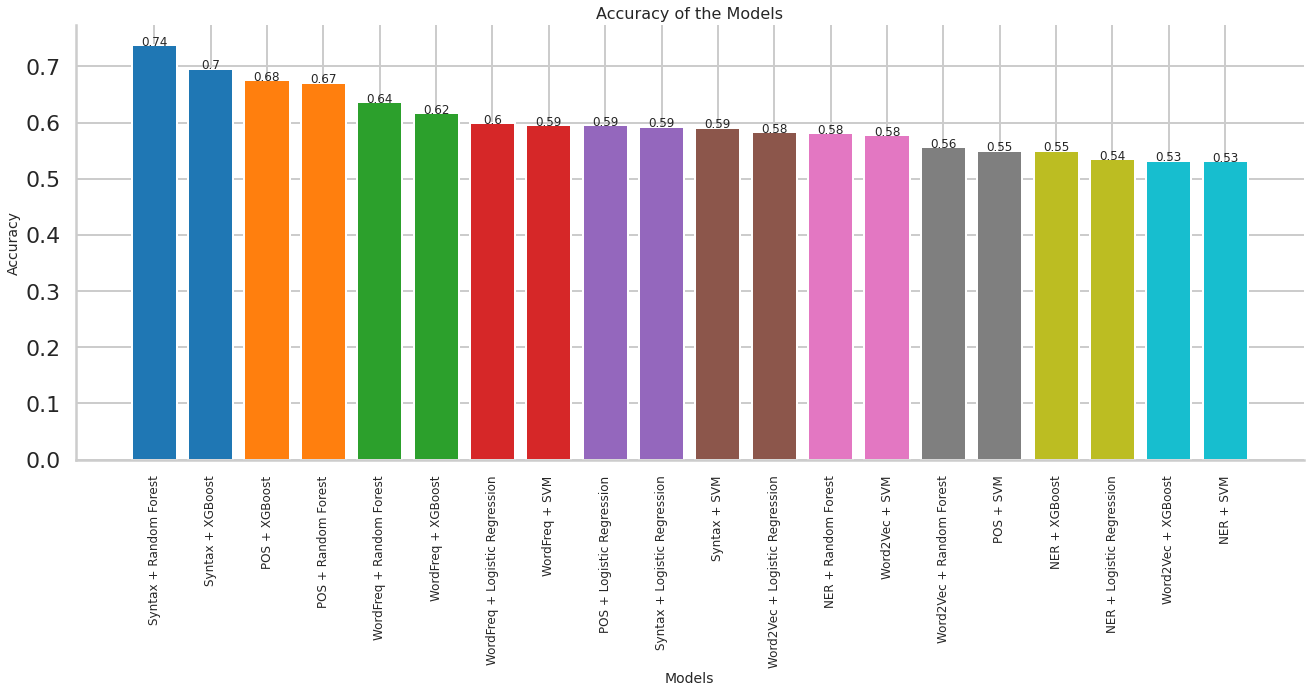

In [91]:
models = df2.sort_values(by=['accuracy', 'f1_score'], ascending=False)

fig, ax = plt.subplots(figsize=(22, 8))

# Define color map
cmap = plt.get_cmap('tab10')

# Define bar chart colors
colors = [cmap(i) for i in np.linspace(0, 1, len(models))]

# Plot the bar chart
ax.bar(models.index, models['accuracy'], color=colors)

# Add labels to each bar
for i, acc in enumerate(models['accuracy']):
    ax.text(i, acc, round(acc, 2), ha='center', fontsize=12)

# Set x-axis tick labels
ax.set_xticklabels(models.index, fontsize=12, rotation=90)

# Add axis labels and title
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title('Accuracy of the Models', fontsize=16)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.savefig('histogram_models2.pdf', dpi=300, bbox_inches='tight')
#plt.show()
#plt.savefig('Summary_plot.pdf')

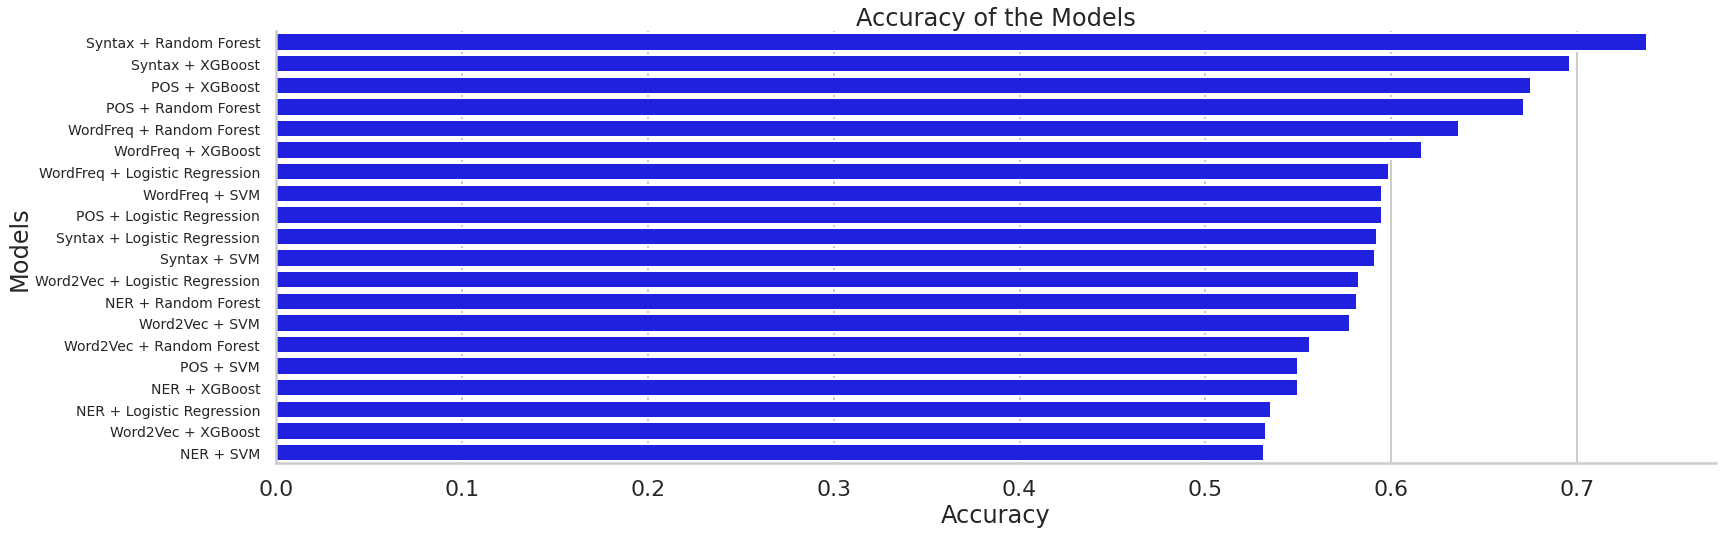

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

models=df2.sort_values(by=['accuracy','f1_score'], ascending=False) # .iloc[:10]

# set style and context using Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

fig = plt.figure(figsize=(20,6))
ax = fig.add_axes([0,0,1,1])

modelz = models.index # or models['Model]
nums = models.accuracy # or models['accuracy']

# use a horizontal bar chart instead
sns.barplot(y=modelz, x=nums, color='blue', ax=ax)


# add labels and title
plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.title('Accuracy of the Models')

# remove spines and set ytick labels size
sns.despine()
ax.tick_params(axis='y', labelsize=14)

plt.savefig('histogram_models3.pdf', dpi=300, bbox_inches='tight')

###### Best pipeline: syntactic_parsing + RandomForestClassifier

In [20]:
X_train_featurized = syntactic_parsing(texts)
classifier = RandomForestClassifier()

# Train the classifier on the training data
classifier.fit(X_train_featurized, labels)
    
# Evaluate the classifier on the validation data
with open('/content/sample_data/test_set.json') as file:
    data_test = json.load(file)

test_tests = [d['text'] for d in data_test]
X_test_featurized =  syntactic_parsing(test_tests)
y_pred = classifier.predict(X_test_featurized)

In [21]:
import csv
# Write predictions to a file
with open("submission2.csv", "w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','label'])
    for i, row in enumerate(y_pred):
        csv_out.writerow([i, row])

#### Group all these Features: 

In [91]:
#!python -m spacy download en_core_web_sm 
#!python -m spacy download en_core_web_md

import spacy
import en_core_web_sm
import en_core_web_md
nlp = en_core_web_sm.load()

In [30]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import spacy

# nlp = spacy.load('en_core_web_sm')
nlp = en_core_web_sm.load()
stop_words = stopwords.words('english')

def extract_features(texts):
    # Word frequency features
    vectorizer = CountVectorizer(stop_words=stop_words)
    word_freq = vectorizer.fit_transform(texts)
    
    # Syntax features
    syntax = []
    for text in texts:
        doc = nlp(text)
        syntax.append([token.pos_ for token in doc])
    
    # Semantics features
    # embeddings = spacy.load('en_core_web_md')
    embeddings = en_core_web_md.load()
    embeddings_dim = embeddings.vocab.vectors_length
    embeddings_matrix = np.zeros((len(texts), embeddings_dim))
    for i, text in enumerate(texts):
        doc = embeddings(text)
        if len(doc) > 0:
            embeddings_matrix[i] = np.mean(doc.vector, axis=0)
    semantics = embeddings_matrix
    
    # Style features
    sentiment = []
    for text in texts:
        doc = nlp(text)
        sentiment.append(doc.sentiment.polarity)
    
    # Pragmatics features
    vectorizer = TfidfVectorizer(stop_words=stop_words)
    tfidf = vectorizer.fit_transform(texts)
    lda = LatentDirichletAllocation(n_components=10, random_state=42)
    lda.fit(tfidf)
    pragmatics = lda.transform(tfidf)
    
    # Combine all features
    features = np.concatenate([word_freq.toarray(), np.array(syntax), semantics, np.array(sentiment).reshape(-1, 1), pragmatics], axis=1)
    
    return features

In [91]:
X = extract_features(texts)
# y = [0]*len(human_features) + [1]*len(ai_features)  # 0 for human-written, 1 for AI-generated
y= labels
# Step 4: Classifier selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Model training and evaluation
svm_classifier= SVC(kernel='linear')
rf_classifier= RandomForestClassifier()
nb_classifier= MultinomialNB()
XG = XGBClassifier()
classifiers = [svm_classifier, rf_classifier, nb_classifier,XG ]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(type(classifier).__name__)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

### 4. Initializing the pre-trained models


In [ ]:
# load BERT pre-trained model
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
                                                                num_labels = 2, # The number of output labels--2 for binary classification.  
                                                                output_attentions = False, # Whether the model returns attentions weights.
                                                                output_hidden_states = False # Whether the model returns all hidden-states.
                                                          )
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# Tell pytorch to run this model on the GPU.
bert_model.to(device)
# RoBERTa
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", # 12-layer, 768-hidden, 12-heads, 125M parameters RoBERTa using the BERT-base architecture
                                                                    num_labels = 2, # The number of output labels--2 for binary classification.
                                                                    output_attentions = False, # Whether the model returns attentions weights.
                                                                    output_hidden_states = False # Whether the model returns all hidden-states.
                                                                )
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tell pytorch to run this model on the GPU.
roberta_model.to(device)
#XLNet
xlnet_model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased",
                                                             num_labels = 2, # The number of output labels--2 for binary classification.
                                                            output_attentions = False, # Whether the model returns attentions weights.
                                                            output_hidden_states = False # Whether the model returns all hidden-states.
                                                             )
xlnet_tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")
xlnet_model.to(device)
print(' Base models loaded')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.weight', 'logits_proj.bias', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

 Base models loaded


### 5. Tokenization

In [ ]:
# Print the original sentence.
print('Original sentences: ', sentences[0])
# Print the tweet split into tokens and tokens_id of BERT
print('Tokenized BERT: ', bert_tokenizer.tokenize(sentences[0]))
print('Token IDs BERT: ', bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(sentences[0])))
# Print the tweet split into tokens and tokens_id of RoBERRTa
print('Tokenized RoBERTa: ', roberta_tokenizer.tokenize(sentences[0]))
print('Token IDs RoBERTa: ', roberta_tokenizer.convert_tokens_to_ids(roberta_tokenizer.tokenize(sentences[0])))
# Print the tweet split into tokens and tokens_id of XLNet
print('Tokenized XLNet: ', xlnet_tokenizer.tokenize(sentences[0]))
print('Token IDs XLNet: ', xlnet_tokenizer.convert_tokens_to_ids(xlnet_tokenizer.tokenize(sentences[0])))

Original sentences:  Remains dating to the 5th century were found in tomb in Hwangnam-dong . Show a man 's bones on top of a woman 's who was buried with jewellery . Experts believe Silla Dynasty-era tomb was built for a noblewoman and her lover or bodyguard was sacrificed and buried on top of her . There 's a suggestion that the set-up may have been designed to show two people having sex - and the Silla were known for their explicit pottery .
Tokenized BERT:  ['remains', 'dating', 'to', 'the', '5th', 'century', 'were', 'found', 'in', 'tomb', 'in', 'h', '##wang', '##nam', '-', 'dong', '.', 'show', 'a', 'man', "'", 's', 'bones', 'on', 'top', 'of', 'a', 'woman', "'", 's', 'who', 'was', 'buried', 'with', 'jewellery', '.', 'experts', 'believe', 'si', '##lla', 'dynasty', '-', 'era', 'tomb', 'was', 'built', 'for', 'a', 'noble', '##woman', 'and', 'her', 'lover', 'or', 'bodyguard', 'was', 'sacrificed', 'and', 'buried', 'on', 'top', 'of', 'her', '.', 'there', "'", 's', 'a', 'suggestion', 'that'

In [ ]:
# Tokenize all train sentences
max_len_bert = 0
max_len_roberta = 0
max_len_xlnet = 0
# loop over sentences to tokenize all sentences 
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids_bert = bert_tokenizer.encode(sent, add_special_tokens=True)
    input_ids_roberta = roberta_tokenizer.encode(sent, add_special_tokens=True)
    input_ids_xlnet = xlnet_tokenizer.encode(sent,add_special_tokens=True)
    # Update the maximum sentence length.
    max_len_bert = max(max_len_bert, len(input_ids_bert))
    max_len_roberta = max(max_len_roberta, len(input_ids_roberta))
    max_len_xlnet = max(max_len_xlnet, len(input_ids_xlnet))
print('Max sentence length BERT: ', max_len_bert)
print('Max sentence length RoBERTa: ', max_len_roberta)
print('Max sentence length XLNet: ', max_len_xlnet)

Token indices sequence length is longer than the specified maximum sequence length for this model (740 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (746 > 512). Running this sequence through the model will result in indexing errors


Max sentence length BERT:  830
Max sentence length RoBERTa:  807
Max sentence length XLNet:  978


Now we're ready to perform the real tokenization.

The tokenizer.encode_plus function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special [CLS] and [SEP] tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.
6. The first four features are in tokenizer.encode, but I'm using tokenizer.encode_plus to get the fifth item (attention masks)

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
bert_input_ids = []
bert_attention_masks = []
roberta_input_ids = []
roberta_attention_masks = []
xlnet_input_ids = []
xlnet_attention_masks = []
sentence_ids = []
counter = 0
# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    
    # tokenize for bert
    bert_encoded_dict = bert_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 360,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    #tokenize for roberta
    roberta_encoded_dict = roberta_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 360,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    xlnet_encoded_dict = xlnet_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 360,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # Add the encoded sentence to the list.    
    bert_input_ids.append(bert_encoded_dict['input_ids'])
    roberta_input_ids.append(roberta_encoded_dict['input_ids'])
    xlnet_input_ids.append(xlnet_encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    bert_attention_masks.append(bert_encoded_dict['attention_mask'])
    roberta_attention_masks.append(roberta_encoded_dict['attention_mask'])
    xlnet_attention_masks.append(xlnet_encoded_dict['attention_mask'])
    
    # collecting sentence_ids
    sentence_ids.append(counter)
    counter  = counter + 1
    
    
    
# Convert the lists into tensors.
bert_input_ids = torch.cat(bert_input_ids, dim=0)
bert_attention_masks = torch.cat(bert_attention_masks, dim=0)

roberta_input_ids = torch.cat(roberta_input_ids, dim=0)
roberta_attention_masks = torch.cat(roberta_attention_masks, dim=0)

xlnet_input_ids = torch.cat(xlnet_input_ids, dim=0)
xlnet_attention_masks = torch.cat(xlnet_attention_masks, dim=0)

labels = torch.tensor(labels)
sentence_ids = torch.tensor(sentence_ids)

print('Data is tokenized!!!!')
# Print sentence 0, now as a list of IDs.
# print('Original: ', sentences[1])
# print('Token IDs BERT:', bert_input_ids[1])
# print('Token IDs RoBERTa:', roberta_input_ids[1])
# print('Token IDs XLNet:', xlnet_input_ids[1])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

Data is tokenized!!!!


### 6. Training & Validation Split

In [ ]:
from torch.utils.data import TensorDataset, random_split
# function to seed the script globally
torch.manual_seed(0)

# Combine the training inputs into a TensorDataset.
bert_dataset = TensorDataset(sentence_ids, bert_input_ids, bert_attention_masks, labels)
roberta_dataset = TensorDataset(roberta_input_ids, roberta_attention_masks, labels)
xlnet_dataset = TensorDataset(xlnet_input_ids, xlnet_attention_masks, labels)

In [ ]:
# function to remove sentice ids from the tensor dataset post train test split
def index_remover(tensordata):
    input_ids = []
    attention_masks = []
    labels = []
   
    for a,b,c,d in tensordata:
        input_ids.append(b.tolist())
        attention_masks.append(c.tolist())
        labels.append(d.tolist())
        
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)
    
    final_dataset =  TensorDataset(input_ids, attention_masks, labels)
    return final_dataset
        
# check
trial_dataset =  index_remover(bert_dataset)
trial_dataset[0]
# yes we were able to remove the sentence id from the data without disturbing the data format

(tensor([  101,  3464,  5306,  2000,  1996,  4833,  2301,  2020,  2179,  1999,
          8136,  1999,  1044, 16600, 13129,  1011, 11947,  1012,  2265,  1037,
          2158,  1005,  1055,  5944,  2006,  2327,  1997,  1037,  2450,  1005,
          1055,  2040,  2001,  3950,  2007, 21545,  1012,  8519,  2903,  9033,
          4571,  5321,  1011,  3690,  8136,  2001,  2328,  2005,  1037,  7015,
         10169,  1998,  2014,  7089,  2030, 16174,  2001, 20268,  1998,  3950,
          2006,  2327,  1997,  2014,  1012,  2045,  1005,  1055,  1037, 10293,
          2008,  1996,  2275,  1011,  2039,  2089,  2031,  2042,  2881,  2000,
          2265,  2048,  2111,  2383,  3348,  1011,  1998,  1996,  9033,  4571,
          2020,  2124,  2005,  2037, 13216, 11378,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [ ]:
# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(bert_dataset))
val_size = len(bert_dataset) - train_size

# Divide the dataset by randomly selecting samples.
bert_train_dataset, bert_val_dataset = random_split(bert_dataset, [train_size, val_size])
roberta_train_dataset, roberta_val_dataset = random_split(roberta_dataset, [train_size, val_size])
xlnet_train_dataset, xlnet_val_dataset = random_split(xlnet_dataset, [train_size, val_size])
# Checking whether the distribution of target is consitent across both the sets
sentence_ids_list_valid = []
for a,b,c,d in bert_val_dataset:
  sentence_ids_list_valid.append(a.tolist())

# removing sentence ids from tensor dataset so that it can be used for training 
bert_train_dataset = index_remover(bert_train_dataset)
bert_val_dataset = index_remover(bert_val_dataset)



# Checking whether the distribution of target is consitent across both the sets
label_temp_list = []
for a,b,c in bert_train_dataset:
  label_temp_list.append(c)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} training samples with AI generated text'.format(sum(label_temp_list)))


label_temp_list = []
for a,b,c in bert_val_dataset:
  label_temp_list.append(c)

print('{:>5,} validation samples'.format(val_size))
print('{:>5,} validation samples with AI generated text'.format(sum(label_temp_list)))

3,600 training samples
1,812 training samples with AI generated text
  400 validation samples
  204 validation samples with AI generated text


### Data Loader

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
bert_train_dataloader = DataLoader(
            bert_train_dataset,  # The training samples.
            sampler = RandomSampler(bert_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
roberta_train_dataloader = DataLoader(
            roberta_train_dataset,  # The training samples.
            sampler = RandomSampler(roberta_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
)
xlnet_train_dataloader = DataLoader(
            xlnet_train_dataset,  # The training samples.
            sampler = RandomSampler(xlnet_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
)


# For validation the order doesn't matter, so we'll just read them sequentially.
bert_validation_dataloader = DataLoader(
            bert_val_dataset, # The validation samples.
            sampler = SequentialSampler(bert_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

roberta_validation_dataloader = DataLoader(
            roberta_val_dataset, # The validation samples.
            sampler = SequentialSampler(roberta_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
xlnet_validation_dataloader = DataLoader(
            xlnet_val_dataset, # The validation samples.
            sampler = SequentialSampler(xlnet_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

Browse our model:

The embedding layer.
The first of the twelve transformers.
The output layer

In [ ]:
# Get all of the model's parameters as a list of tuples.
# params = list(bert_model.named_parameters())
params = list(roberta_model.named_parameters())
# params = list(xlnet_model.named_parameters())

print('The RoBERTa model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The RoBERTa model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias         

### 7. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values :

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4
We chose:

Batch size: 32 (set when creating our DataLoaders)
Learning rate: 2e-5
Epochs: 4 (we'll see that this is probably too many...)
The epsilon parameter eps = 1e-8 is "a very small number to prevent any division by zero in the implementation"

In [ ]:
param_optimizer1 = list(bert_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters1 = [
    {'params': [p for n, p in param_optimizer1 if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer1 if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
param_optimizer2 = list(roberta_model.named_parameters())
optimizer_grouped_parameters2 = [
    {'params': [p for n, p in param_optimizer2 if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer2 if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
param_optimizer3 = list(xlnet_model.named_parameters())
optimizer_grouped_parameters3 = [
    {'params': [p for n, p in param_optimizer3 if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer3 if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
bert_optimizer = AdamW(optimizer_grouped_parameters1,
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
roberta_optimizer = AdamW(optimizer_grouped_parameters2,
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
xlnet_optimizer = AdamW(optimizer_grouped_parameters3,
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 2
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(bert_train_dataloader) * epochs
# Create the learning rate scheduler.
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
roberta_scheduler = get_linear_schedule_with_warmup(roberta_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
xlnet_scheduler = get_linear_schedule_with_warmup(xlnet_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### 8. Training Loop

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as hh:mm:ss

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

#### XLNet

In [ ]:
import random
# Set the seed value all over the place to make this reproducible.
seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

xlnet_training_stats = []
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_train_loss = 0
    xlnet_model.train()
    # For each batch of training data...
    for step, batch in enumerate(xlnet_train_dataloader):
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        xlnet_model.zero_grad()        
        output = xlnet_model(b_input_ids, 
#                              token_type_ids=None, 
                            #  attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = output.loss
        logits = output.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(xlnet_model.parameters(), 1.0)
        xlnet_optimizer.step()
        xlnet_scheduler.step()
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(xlnet_train_dataloader)            
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")
    t0 = time.time()
    xlnet_model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in xlnet_validation_dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():       
            output = xlnet_model(b_input_ids, 
#                              token_type_ids=None, 
                            #  attention_mask=b_input_mask, 
                             labels=b_labels)
            loss = output.loss
            logits = output.logits
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(xlnet_validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(xlnet_validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    xlnet_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.66
  Training epcoh took: 0:01:23

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.44
  Validation took: 0:00:03

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.36
  Training epcoh took: 0:01:19

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.34
  Validation took: 0:00:03

Training complete!
Total training took 0:02:48 (h:mm:ss)


#### 8.1 BERT

In [ ]:
import random
# Set the seed value all over the place to make this reproducible.
seed_val = 100
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

bert_training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_train_loss = 0
    bert_model.train()
    # For each batch of training data...
    for step, batch in enumerate(bert_train_dataloader):
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        bert_model.zero_grad()       
        output = bert_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = output.loss
        logits = output.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        bert_optimizer.step()
        bert_scheduler.step()
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(bert_train_dataloader)            
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")
    t0 = time.time()
    bert_model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in bert_validation_dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            output = bert_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
            loss = output.loss
            logits = output.logits       
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(bert_validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(bert_validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    bert_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.55
  Training epcoh took: 0:00:56

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.43
  Validation took: 0:00:02

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.26
  Training epcoh took: 0:00:56

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.59
  Validation took: 0:00:02

Training complete!
Total training took 0:01:56 (h:mm:ss)


#### 8.2 RoBERTa

In [ ]:
import random
# Set the seed value all over the place to make this reproducible.
seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

roberta_training_stats = []
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_train_loss = 0
    roberta_model.train()
    # For each batch of training data...
    for step, batch in enumerate(roberta_train_dataloader):
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        roberta_model.zero_grad()        
        output = roberta_model(b_input_ids, 
#                              token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = output.loss
        logits = output.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(roberta_model.parameters(), 1.0)
        roberta_optimizer.step()
        roberta_scheduler.step()
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(roberta_train_dataloader)            
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")
    t0 = time.time()
    roberta_model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in roberta_validation_dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():       
            output = roberta_model(b_input_ids, 
#                              token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
            loss = output.loss
            logits = output.logits
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(roberta_validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(roberta_validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    roberta_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.46
  Training epcoh took: 0:00:56

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.30
  Validation took: 0:00:02

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.21
  Training epcoh took: 0:00:56

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.32
  Validation took: 0:00:02

Training complete!
Total training took 0:01:56 (h:mm:ss)


### 9. Evaluation 

In [ ]:
pd.set_option('precision', 2)
xlnet_stats = pd.DataFrame(data=xlnet_training_stats)
xlnet_stats = xlnet_stats.set_index('epoch')
xlnet_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.66,0.44,0.78,0:01:23,0:00:03
2,0.36,0.34,0.85,0:01:19,0:00:03


In [ ]:
pd.set_option('precision', 2)
bert_stats = pd.DataFrame(data=bert_training_stats)
bert_stats = bert_stats.set_index('epoch')
bert_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.55,0.43,0.8,0:00:56,0:00:02
2,0.26,0.59,0.8,0:00:56,0:00:02


In [ ]:
pd.set_option('precision', 2)
roberta_stats = pd.DataFrame(data=roberta_training_stats)
roberta_stats = roberta_stats.set_index('epoch')
roberta_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.46,0.30,0.88,0:00:56,0:00:02
2,0.21,0.32,0.88,0:00:56,0:00:02


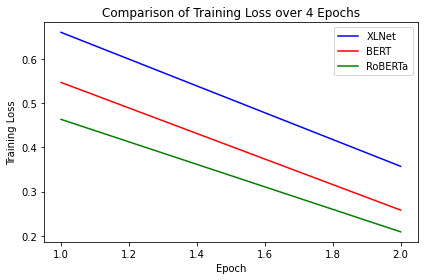

In [ ]:
#compare training loss of 3 models
epochs = [1, 2]

plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots()

ax.plot(epochs, xlnet_stats['Training Loss'], color='blue', label='XLNet')
ax.plot(epochs, bert_stats['Training Loss'], color='red', label='BERT')
ax.plot(epochs, roberta_stats['Training Loss'], color='green', label='RoBERTa')

ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.legend()

ax.set_title('Comparison of Training Loss over 4 Epochs')
fig.tight_layout()

plt.show()


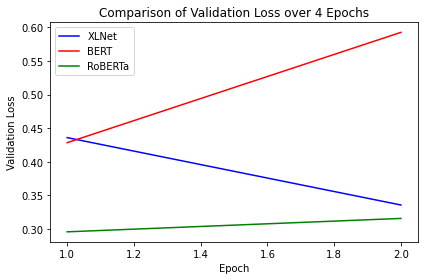

In [ ]:
#compare training loss of 3 models
epochs = [1, 2]

plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots()

ax.plot(epochs, xlnet_stats['Valid. Loss'], color='blue', label='XLNet')
ax.plot(epochs, bert_stats['Valid. Loss'], color='red', label='BERT')
ax.plot(epochs, roberta_stats['Valid. Loss'], color='green', label='RoBERTa')

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss')
ax.legend()

ax.set_title('Comparison of Validation Loss over 4 Epochs')
fig.tight_layout()

plt.show()


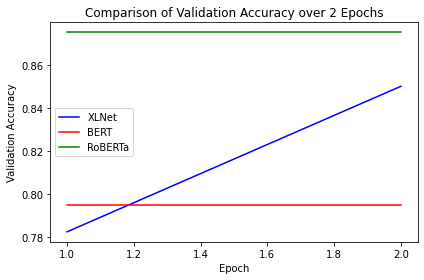

In [ ]:
#compare valid accur of 3 models
epochs = [1, 2]

plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots()

ax.plot(epochs, xlnet_stats['Valid. Accur.'], color='blue', label='XLNet')
ax.plot(epochs, bert_stats['Valid. Accur.'], color='red', label='BERT')
ax.plot(epochs, roberta_stats['Valid. Accur.'], color='green', label='RoBERTa')

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy')
ax.legend()

ax.set_title('Comparison of Validation Accuracy over 2 Epochs')
fig.tight_layout()

plt.show()


We see that after 2 epochs, the validation loss is increasing which means that the model is overfitted. So we will choose number of epochs = 2 and we will focus on RoBERTa, since it gives the best performance at epochs 2.

### 10. Detalied Evaluation on Test data

In this scenario I shall pickup the validation dataset which was eariler created and shall use it for prediction. The features have already been created on the data so I would just use them for evaluation of our model as well

In [ ]:
# Load the dataset into a pandas dataframe.
df  = train_df.iloc[sentence_ids_list_valid,]

In [ ]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.text.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = roberta_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 360,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 16

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
# prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 400



/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
roberta_model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
#   b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = roberta_model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')


Predicting labels for 400 test sentences...
    DONE.


In [ ]:
# print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
test_df = pd.read_json('./test_set.json')
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

Number of training sentences: 4,000



In [ ]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

sentences = test_df.text.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = roberta_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 360,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
# Set the batch size.  
batch_size = 16
# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)
# prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 4,000



<ipython-input-42-8c8b169d3ad7>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [ ]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
# Put model in evaluation mode
roberta_model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
#   b_input_ids, b_input_mask = batch
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = roberta_model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('    DONE.')


Predicting labels for 4,000 test sentences...
    DONE.


In [ ]:
# Flatten the predictions list
predictions = np.concatenate(predictions, axis=0)
print('Shape of predictions:', predictions.shape)

Shape of predictions: (4000, 2)


In [ ]:
print(predictions[1])

[ 0.41989496 -0.192219  ]


In [ ]:
from scipy.special import softmax

# Apply softmax to the logits to convert them into probabilities
probs = softmax(predictions, axis=1)

# Convert the probabilities into binary predictions by choosing the class with the highest probability
binary_preds = np.argmax(probs, axis=1)

# Print the first 10 binary predictions
print(binary_preds)

[0 0 1 ... 1 0 0]


In [ ]:
import csv
# Write predictions to a file
with open("submission.csv", "w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','label'])
    for i, row in enumerate(binary_preds):
        csv_out.writerow([i, row])